In [1]:

from google.colab import files
files.upload()
!pip install kaggle  # Only first time
!mkdir ~/.kaggle
# Upload kaggle.json (API key) in Colab, or use your local one
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d fatimahirshad/faceforensics-extracted-dataset-c23
!unzip -q faceforensics-extracted-dataset-c23.zip -d /content/

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/fatimahirshad/faceforensics-extracted-dataset-c23
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 3.78G/3.78G [01:02<00:00, 261MB/s]
100% 3.78G/3.78G [01:02<00:00, 65.2MB/s]


In [2]:
# ============================================================================
# ------------------------- Bloc 1 ------------------------------------------
# ============================================================================
import os
import random
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report

try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda x: x

try:
    import timm
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "timm"])
    import timm

# ---------------- CONFIG ----------------
DATA_ROOT = r"/content/FF++C32-Frames"
IMG_SIZE = 299
BATCH_SIZE = 32
RANDOM_SEED = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15
EPOCHS = 15
LR = 1e-4
WEIGHT_DECAY = 1e-5
NUM_WORKERS = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if device == 'cuda':
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda



 Chargement du dataset FaceForensics++...

 Statistiques du dataset :
  • Images Original : 5000
  • Images Deepfake : 5000
  • Total images : 10000
  • Ratio Original/Deepfake : 1.00


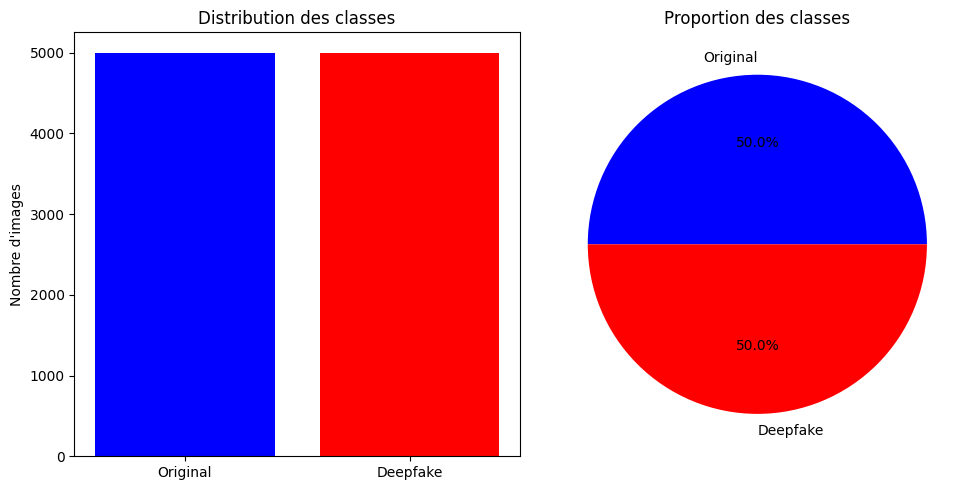

In [3]:
# ============================================================================
# ----- Bloc 2 : CHARGEMENT ET ANALYSE DU DATASET FACE FORENSICS++ -----------
# ============================================================================
print("\n Chargement du dataset FaceForensics++...")

original_images = glob(os.path.join(DATA_ROOT, "Original", "*.jpg"))
deepfake_images = glob(os.path.join(DATA_ROOT, "Deepfakes", "*.jpg"))

if len(original_images) == 0 or len(deepfake_images) == 0:
    raise RuntimeError(f" Aucune image trouvée. Vérifiez le chemin : {DATA_ROOT}")

images = original_images + deepfake_images
labels = [0]*len(original_images) + [1]*len(deepfake_images)

# Analyse du dataset
print(f"\n Statistiques du dataset :")
print(f"  • Images Original : {len(original_images)}")
print(f"  • Images Deepfake : {len(deepfake_images)}")
print(f"  • Total images : {len(images)}")
print(f"  • Ratio Original/Deepfake : {len(original_images)/len(deepfake_images):.2f}")

# Visualisation de la distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Original', 'Deepfake'], [len(original_images), len(deepfake_images)],
        color=['blue', 'red'])
plt.title('Distribution des classes')
plt.ylabel('Nombre d\'images')

plt.subplot(1, 2, 2)
plt.pie([len(original_images), len(deepfake_images)],
        labels=['Original', 'Deepfake'],
        colors=['blue', 'red'],
        autopct='%1.1f%%')
plt.title('Proportion des classes')
plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=150)
plt.show()

In [5]:
# ============================================================================
# ----------------------Bloc 3 : SPLIT DES DONNÉES ---------------------------
# ============================================================================
print("\n Split stratifié des données...")

combined = list(zip(images, labels))
random.shuffle(combined)
images, labels = zip(*combined)

# Split dataset
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    images, labels, test_size=(TEST_SIZE + VAL_SIZE),
    random_state=RANDOM_SEED, stratify=labels
)

val_size_ratio = VAL_SIZE / (TEST_SIZE + VAL_SIZE)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=1 - val_size_ratio,
    random_state= RANDOM_SEED, stratify=temp_labels
)

print(f" Dataset splité avec succès :")
print(f"  • Entraînement : {len(train_imgs)} images")
print(f"  • Validation   : {len(val_imgs)} images")
print(f"  • Test         : {len(test_imgs)} images")



 Split stratifié des données...
 Dataset splité avec succès :
  • Entraînement : 7000 images
  • Validation   : 1500 images
  • Test         : 1500 images


In [6]:
# ============================================================================
# TRANSFORMS ET DATASET
# ============================================================================
# ---------------- TRANSFORMS ----------------
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# CUSTOM DATASET
class SimpleFaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = list(image_paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = int(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, label

# Création des datasets
train_dataset = SimpleFaceDataset(train_imgs, train_labels, transform_train)
val_dataset = SimpleFaceDataset(val_imgs, val_labels, transform_test)
test_dataset = SimpleFaceDataset(test_imgs, test_labels, transform_test)

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ============================================================================
# MODÈLE ET ENTRAÎNEMENT
# ============================================================================
# ---------------- MODEL: Xception (pretrained via timm) ----------------
model = timm.create_model('xception', pretrained=True, num_classes=2)
model = model.to(device)

# Optionally freeze most of the backbone for faster convergence; here we fine-tune last stages
for name, param in model.named_parameters():
    # keep batchnorm and classifier trainable - freeze early layers
    if 'fc' in name or 'classifier' in name:
        param.requires_grad = True
    else:
        # you can unfreeze more layers if needed
        param.requires_grad = True

# Loss with class weights (in case of class imbalance)
from collections import Counter
counter = Counter(train_labels)
class_counts = np.array([counter[0], counter[1]])
class_weights = class_counts.sum() / (2.0 * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# ---------------- TRAIN / EVAL FUNCTIONS ----------------
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def evaluate(loader):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    loss = running_loss / (len(loader.dataset))
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    return loss, acc, prec, rec, f1, cm, all_labels, all_preds

# ---------------- TRAIN LOOP ----------------
best_val_f1 = 0.0
best_state = None
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_cm, _, _ = evaluate(val_loader)
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"  LR reduced from {old_lr:.6e} -> {new_lr:.6e}")

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # Save best model by val F1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = { 'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch }
        torch.save(best_state, 'best_xception_checkpoint.pth')
        print('  --> New best model saved')

# Load best model for final evaluation
if best_state is not None:
    model.load_state_dict(best_state['model'])

# ---------------- TEST / METRICS ----------------
print('\n--- FINAL TEST EVALUATION ---')
test_loss, test_acc, test_prec, test_rec, test_f1, test_cm, true_labels, pred_labels = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")
print(f"Test Prec: {test_prec:.4f}")
print(f"Test Rec : {test_rec:.4f}")
print(f"Test F1  : {test_f1:.4f}")
print('\nConfusion Matrix:')
print(test_cm)
print('\nClassification Report:')
print(classification_report(true_labels, pred_labels, digits=4))

# Save metrics to a file
with open('test_metrics.txt', 'w') as f:
    f.write(f"Test Loss: {test_loss:.6f}\n")
    f.write(f"Test Acc : {test_acc:.6f}\n")
    f.write(f"Test Prec: {test_prec:.6f}\n")
    f.write(f"Test Rec : {test_rec:.6f}\n")
    f.write(f"Test F1  : {test_f1:.6f}\n")
    f.write('\nConfusion Matrix:\n')
    f.write(np.array2string(test_cm))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


100%|██████████| 219/219 [03:47<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/15
  Train Loss: 0.5510 | Train Acc: 0.6819
  Val   Loss: 0.4108 | Val   Acc: 0.7953 | Val F1: 0.8149
  --> New best model saved


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:48<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/15
  Train Loss: 0.2741 | Train Acc: 0.8766
  Val   Loss: 0.2671 | Val   Acc: 0.8820 | Val F1: 0.8908
  --> New best model saved


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:47<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/15
  Train Loss: 0.1706 | Train Acc: 0.9263
  Val   Loss: 0.1872 | Val   Acc: 0.9247 | Val F1: 0.9207
  --> New best model saved


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:48<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/15
  Train Loss: 0.1313 | Train Acc: 0.9481
  Val   Loss: 0.1333 | Val   Acc: 0.9480 | Val F1: 0.9492
  --> New best model saved


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:49<00:00,  1.05s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/15
  Train Loss: 0.0984 | Train Acc: 0.9630
  Val   Loss: 0.1124 | Val   Acc: 0.9640 | Val F1: 0.9634
  --> New best model saved


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:48<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/15
  Train Loss: 0.0806 | Train Acc: 0.9683
  Val   Loss: 0.0855 | Val   Acc: 0.9660 | Val F1: 0.9659
  --> New best model saved


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:48<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/15
  Train Loss: 0.0589 | Train Acc: 0.9790
  Val   Loss: 0.1312 | Val   Acc: 0.9507 | Val F1: 0.9493


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:50<00:00,  1.05s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/15
  Train Loss: 0.0549 | Train Acc: 0.9779
  Val   Loss: 0.0892 | Val   Acc: 0.9660 | Val F1: 0.9666
  --> New best model saved


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:49<00:00,  1.05s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/15
  Train Loss: 0.0496 | Train Acc: 0.9806
  Val   Loss: 0.0766 | Val   Acc: 0.9720 | Val F1: 0.9723
  --> New best model saved


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:48<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/15
  Train Loss: 0.0401 | Train Acc: 0.9859
  Val   Loss: 0.0810 | Val   Acc: 0.9700 | Val F1: 0.9701


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:48<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/15
  Train Loss: 0.0386 | Train Acc: 0.9853
  Val   Loss: 0.0801 | Val   Acc: 0.9687 | Val F1: 0.9686


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:48<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/15
  Train Loss: 0.0399 | Train Acc: 0.9859
  Val   Loss: 0.0533 | Val   Acc: 0.9793 | Val F1: 0.9794
  --> New best model saved


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:48<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/15
  Train Loss: 0.0295 | Train Acc: 0.9909
  Val   Loss: 0.1012 | Val   Acc: 0.9693 | Val F1: 0.9686


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:48<00:00,  1.04s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/15
  Train Loss: 0.0306 | Train Acc: 0.9899
  Val   Loss: 0.0519 | Val   Acc: 0.9787 | Val F1: 0.9784


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [03:49<00:00,  1.05s/it]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/15
  Train Loss: 0.0254 | Train Acc: 0.9906
  Val   Loss: 0.1018 | Val   Acc: 0.9673 | Val F1: 0.9666

--- FINAL TEST EVALUATION ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 0.0920
Test Acc : 0.9707
Test Prec: 0.9930
Test Rec : 0.9480
Test F1  : 0.9700

Confusion Matrix:
[[745   5]
 [ 39 711]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9503    0.9933    0.9713       750
           1     0.9930    0.9480    0.9700       750

    accuracy                         0.9707      1500
   macro avg     0.9716    0.9707    0.9707      1500
weighted avg     0.9716    0.9707    0.9707      1500

